In [84]:
%matplotlib inline
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

import glob
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor

from src.data.processing_func import connect_database, extract_geo_sections

from IPython.display import display
pd.options.display.max_columns = 30


Load median flow per hour:

In [7]:
median_flow_per_hour = pd.read_csv(project_dir + "/data/interim/20180405_SGMK_median_per_hour.csv", index_col=0)
display(median_flow_per_hour.shape)
display(median_flow_per_hour.sample(5))

(2976, 11)

,Endereco,Sentido,Equipamento,hour,Latitude,Longitude,Numero de Faixas,Corredor,Total,total_por_faixa,weighted_avg_speed
1629,Rua Inácio Bastos. 770,Oeste/Leste,FS559JOI,21,-26.31602,-48.83758,2.0,0.0,622.0,311.00,43.165583
10,Av. Aluisio Pires Condeixa. 2700,Sul/Norte,FS593JOI,10,-26.27918,-48.84623,2.0,0.0,553.0,276.50,45.903019
1480,Rua Graciosa. 1000,Norte/Sul,FS558JOI,16,-26.31945,-48.83094,2.0,0.0,1369.0,684.50,42.071597
385,Av. Plácido Hugo de Oliveira Próx. Rua Santa C...,S/N,FS615JOI,1,-26.37868,-48.84337,2.0,0.0,39.5,19.75,49.755245
869,Rua Benjamin Constant 650,Leste/Oeste,FS644JOI,5,-26.28445,-48.85526,1.0,0.0,37.0,37.00,44.473684


Load waze data:

In [6]:
#Get processed datasets
filenames = glob.glob(project_dir+"/data/interim/temp_df_jps_2017_10_1*")
filenames.sort()
frame = pd.DataFrame()
list_ = []
for file_ in filenames:
    df = pd.read_csv(file_, index_col=0)
    list_.append(df)
df_jps = pd.concat(list_)
display(df_jps.shape)
display(df_jps.sample(5))

(760635, 18)

,MgrcDateStart,JpsId,SctnId,JamId,JamIndLevelOfTraffic,JamQtdLengthMeters,JamSpdMetersPerSecond,JamTimeDelayInSeconds,JamDscCoordinatesLonLat,JamSpdKmPerHour,LonDirection,LatDirection,MajorDirection,date,hour,minute,period,minute_bin
7966,2017-10-16 18:06:00-02:00,6495907.0,8002.0,525695.0,4.0,460.0,1.994444,175.0,"[{'x': -48.850431, 'y': -26.31903}, {'x': -48....",7.18,West,South,Leste/Oeste,2017-10-16,18,6,1,0 a 14
1702,2017-12-11 08:22:00-02:00,7693600.0,7877.0,777047.0,3.0,300.0,2.025000,71.0,"[{'x': -48.861497, 'y': -26.306868}, {'x': -48...",7.29,West,North,Leste/Oeste,2017-12-11,8,22,-1,15 a 29
18222,2017-12-05 17:42:00-02:00,7619163.0,9253.0,746257.0,3.0,281.0,2.227778,98.0,"[{'x': -48.82577, 'y': -26.272945}, {'x': -48....",8.02,East,North,Leste/Oeste,2017-12-05,17,42,1,30 a 44
34802,2017-12-21 17:12:00-02:00,7956842.0,6092.0,837177.0,3.0,1121.0,4.500000,161.0,"[{'x': -48.821003, 'y': -26.246326}, {'x': -48...",16.20,East,South,Norte/Sul,2017-12-21,17,12,1,0 a 14
24871,2017-11-07 17:25:00-02:00,6939162.0,12027.0,615038.0,1.0,1099.0,6.272222,71.0,"[{'x': -48.810078, 'y': -26.263997}, {'x': -48...",22.58,West,South,Leste/Oeste,2017-11-07,17,25,1,15 a 29


Load official street sections from the Municipality:

In [12]:
#Connection and initial setup
DATABASE = {
'drivername': os.environ.get("db_drivername"),
'host': os.environ.get("db_host"), 
'port': os.environ.get("db_port"),
'username': os.environ.get("db_username"),
'password': os.environ.get("db_password"),
'database': os.environ.get("db_database"),
}

meta = connect_database(DATABASE)
geo_sections = extract_geo_sections(meta, main_buffer=10)
geo_sections.sample(5)

,SctnId,SctnIdArcgis,SctnCodRua,SctnDscNome,SctnQtdMetrosAcumulados,SctnQtdComprimento,SctnDscCoordxUtmComeco,SctnDscCoordyUtmComeco,SctnDscCoordxUtmMeio,SctnDscCoordyUtmMeio,SctnDscCoordxUtmFinal,SctnDscCoordyUtmFinal,MinX,MaxX,MinY,MaxY,StreetDirection,SectionDirection,Street_line_XY,Street_line_LonLat,section_LineString,section_alt_LineString
12061,12061,28397,1967,CAPRICORNUS,566,43.887324,716771.3040,7.099233e+06,716751.34925,7.099242e+06,716731.3945,7.099251e+06,716731.3945,716771.3040,7.099233e+06,7.099251e+06,Leste/Oeste,Leste/Oeste,"[(716771.304, 7099233.234), (716751.34925, 709...","[(-48.830413013486776, -26.2101189685275), (-4...",POLYGON ((-48.83065423736666 -26.2101222931139...,"POLYGON ((716743.0291710328 7099224.175393857,..."
12481,12481,28822,3466,EDIFICIO DALIA,70,69.877783,713082.6806,7.085836e+06,713084.51695,7.085871e+06,713086.3533,7.085906e+06,713082.6806,713086.3533,7.085836e+06,7.085906e+06,Norte/Sul,Norte/Sul,"[(713082.6806, 7085835.8313), (713084.51695, 7...","[(-48.86509920667527, -26.33155902371508), (-4...",POLYGON ((-48.86518667927732 -26.3312406740390...,"POLYGON ((713064.5445934924 7085871.773078165,..."
8425,8425,24674,5508,JOSE A.DO LIVRAMENTO,68,32.814995,722237.3591,7.090462e+06,722253.75970,7.090463e+06,722270.1603,7.090463e+06,722237.3591,722270.1603,7.090462e+06,7.090463e+06,Leste/Oeste,Leste/Oeste,"[(722237.3591, 7090462.487), (722253.7597, 709...","[(-48.77422973623515, -26.28841925633391), (-4...",POLYGON ((-48.77407028506231 -26.2883222733249...,"POLYGON ((722253.1798431349 7090482.954292383,..."
14023,14023,30402,7227,PENHA,84,84.254523,717248.3213,7.088401e+06,717220.33830,7.088370e+06,717192.3553,7.088338e+06,717192.3553,717248.3213,7.088338e+06,7.088401e+06,Norte/Sul,Norte/Sul,"[(717248.3213, 7088401.1428), (717220.3383, 70...","[(-48.82381982084681, -26.30778484366807), (-4...",POLYGON ((-48.82401870132059 -26.3081320322939...,"POLYGON ((717235.2885240295 7088356.367215941,..."
12732,12732,29085,6803,ODILON ROCHA FERREIRA,708,76.851682,719236.4388,7.093347e+06,719207.41160,7.093322e+06,719178.3844,7.093297e+06,719178.3844,719236.4388,7.093297e+06,7.093347e+06,Leste/Oeste,Leste/Oeste,"[(719236.4388, 7093347.4461), (719207.4116, 70...","[(-48.80475705862659, -26.26285162407286), (-4...",POLYGON ((-48.80526262271984 -26.2633820336137...,"POLYGON ((719191.4894872018 7093281.980533684,..."


Prepare radar data to merge:


In [58]:
#Check whether there are equipment with no information on location
if median_flow_per_hour[[ "Longitude", "Latitude"]].isnull().values.any():
    raise Exception("There are radars with no georeferenced information. Please correct that")

#Clean Latitude and Longitude information
median_flow_per_hour.loc[:,["Longitude", "Latitude"]] = median_flow_per_hour.loc[:,["Longitude", "Latitude"]].replace(to_replace=",", value=".")
median_flow_per_hour.loc[:,["Longitude", "Latitude"]] = median_flow_per_hour.loc[:,["Longitude", "Latitude"]].astype(float)
    
#Crossing algorithm
median_flow_per_hour["fluxo_Point"] = median_flow_per_hour.apply(lambda x: Point(x["Longitude"], x["Latitude"]), axis=1)
direction = {"N": "North",
             "S": "South",
             "Norte": "North",
             "Sul": "South",
             "L": "East",
             "O": "West",
             "Leste": "East",
             "Oeste": "West",}
median_flow_per_hour["Direction"] = median_flow_per_hour["Sentido"].str.split("/", 1).str.get(1).map(direction)
geo_fluxos = gpd.GeoDataFrame(median_flow_per_hour, crs={'init': 'epsg:4326'}, geometry="fluxo_Point")
flow_labels = gpd.sjoin(geo_fluxos, geo_sections.reset_index(), how="left", op="within")
flow_labels.set_index(["SctnId", "hour", "Direction"], inplace=True)
flow_labels = flow_labels[["Endereco",
                           "SctnDscNome",
                           "Street_line_XY",
                           "Equipamento",
                           "Numero de Faixas",
                           "weighted_avg_speed",
                           "total_por_faixa",
                           "Total",
                          ]]
flow_labels.sample(5)

,,,Endereco,SctnDscNome,Street_line_XY,Equipamento,Numero de Faixas,weighted_avg_speed,total_por_faixa,Total
SctnId,hour,Direction,,,,,,,,
12523.0,13,North,Dr. João Colin x Presidente Prudente Moraes,DR. JOAO COLIN,"[(714677.6937, 7092266.48), (714682.14195, 709...",FS655JOI,2.0,30.199195,464.750000,929.5
2745.0,9,East,Rua Inácio Bastos. 770,LAGUNA,"[(715864.2518, 7087512.749), (715866.0522, 708...",FS559JOI,2.0,44.672166,300.000000,600.0
7480.0,8,South,Av. José Vieira X Rua Itaiópolis,ITAIOPOLIS,"[(715339.3594, 7090688.2007), (715308.13495, 7...",FS596JOI,3.0,25.407315,469.333333,1408.0
9665.0,23,East,Rua Waldemiro José Borges. 3528,WALDEMIRO JOSE BORGES,"[(716996.6672, 7080464.7093), (717015.486049, ...",FS637JOI,1.0,47.129331,153.000000,153.0
7392.0,1,West,Rua Max Colin 1629,MAX COLIN,"[(713822.8452, 7089972.7216), (713856.45235, 7...",FS623JOI,3.0,45.931165,31.166667,93.5


There are duplicates in the official street sections from the Municipality. This will have to be dealt with later:

In [47]:
print("Shape before merge", median_flow_per_hour.shape)
print("Shape after merge", flow_labels.shape)
flow_labels.head(2)[["Endereco", "Sentido", "Direction", "Equipamento", "hour",
                     "Total", "SctnId", "SectionDirection", "MinX", "MaxX", "MinY", "MaxY"]]

Shape before merge (2976, 13)
Shape after merge (4056, 36)


,Endereco,Sentido,Direction,Equipamento,hour,Total,SctnId,SectionDirection,MinX,MaxX,MinY,MaxY
425,Av.Dr. Albano Schultz x Rua Princesa Izabel,Norte/Sul,South,FS569JOI,17,2090.5,665.0,Norte/Sul,715398.5435,715417.9469,7.089298e+06,7.089764e+06
425,Av.Dr. Albano Schultz x Rua Princesa Izabel,Norte/Sul,South,FS569JOI,17,2090.5,4961.0,Norte/Sul,715406.4495,715407.8757,7.089299e+06,7.089372e+06


Prepare Waze data for merge

In [97]:
def get_main_direction(x):
    if x["MajorDirection"] == "Norte/Sul":
        return x["LatDirection"]
    elif x["MajorDirection"] == "Leste/Oeste":
        return x["LonDirection"]

flow_features = df_jps.groupby(["SctnId", "hour",
                                       "LonDirection",
                                       "LatDirection",
                                       "MajorDirection"]).agg({"JamIndLevelOfTraffic": "mean",
                                                                "JamSpdKmPerHour": "median",
                                                                "JamTimeDelayInSeconds": "median",
                                                                "JamQtdLengthMeters": "median",
                                                                })

flow_features.reset_index(["LonDirection", "LatDirection", "MajorDirection"], inplace=True)
flow_features["Direction"] = flow_features.apply(lambda x: get_main_direction(x), axis=1)
flow_features.set_index("Direction", append=True, inplace=True)

flow_features.sample(5)

,,,LonDirection,LatDirection,MajorDirection,JamIndLevelOfTraffic,JamSpdKmPerHour,JamTimeDelayInSeconds,JamQtdLengthMeters
SctnId,hour,Direction,,,,,,,
6454.0,8,East,East,North,Leste/Oeste,2.000,24.960,62.0,1009.0
6416.0,18,North,East,North,Norte/Sul,2.750,12.850,102.0,601.0
7902.0,17,South,West,South,Norte/Sul,2.000,16.965,64.0,586.0
9285.0,7,East,East,South,Leste/Oeste,3.208,10.630,194.0,744.0
10181.0,7,West,West,South,Leste/Oeste,2.000,17.330,89.0,881.0


Merge flow and waze data:

In [98]:
flow_dataset = flow_features.merge(flow_labels, how="inner", left_index=True, right_index=True)
display(flow_dataset.shape)
flow_dataset.sample(5)

(380, 15)

,,,LonDirection,LatDirection,MajorDirection,JamIndLevelOfTraffic,JamSpdKmPerHour,JamTimeDelayInSeconds,JamQtdLengthMeters,Endereco,SctnDscNome,Street_line_XY,Equipamento,Numero de Faixas,weighted_avg_speed,total_por_faixa,Total
SctnId,hour,Direction,,,,,,,,,,,,,,,
5138.0,18,North,West,North,Norte/Sul,2.740876,14.470,99.0,784.0,Rua Fátima. 542,FATIMA,"[(717897.377, 7085383.1152), (717898.903721, 7...",FS640JOI,1.0,35.913686,487.000000,487.0
3846.0,17,West,West,South,Leste/Oeste,2.000000,18.885,61.5,722.0,Rua Anitápolis. 245,ANITAPOLIS,"[(717251.3608, 7085012.8974), (717296.09795, 7...",FS630JOI,1.0,31.417786,244.500000,244.5
4604.0,8,North,West,North,Norte/Sul,3.000000,13.220,425.0,2305.0,Rua Tenente Antônio João. 826,TENENTE ANTONIO JOAO,"[(715167.3354, 7092736.1581), (715166.3709, 70...",FS651JOI,2.0,42.066510,528.500000,1057.0
14587.0,8,South,East,South,Norte/Sul,2.666667,16.680,103.0,760.0,Rua Camboriú. 300,CAMBORIU,"[(713379.216, 7088853.3508), (713381.94985, 70...",FS556JOI,1.0,40.955468,612.000000,612.0
5552.0,18,West,West,North,Leste/Oeste,2.919540,9.405,135.0,568.0,Rua Max Colin x Rua Blumenau,MAX COLIN,"[(714636.2383, 7089898.9175), (714750.19765, 7...",FS584JOI,3.0,24.294636,434.166667,1302.5


There seems to be little relationship between Waze's average speed and the radars's median flow:

Text(0,0.5,'Fluxo (carros/h/faixa)')

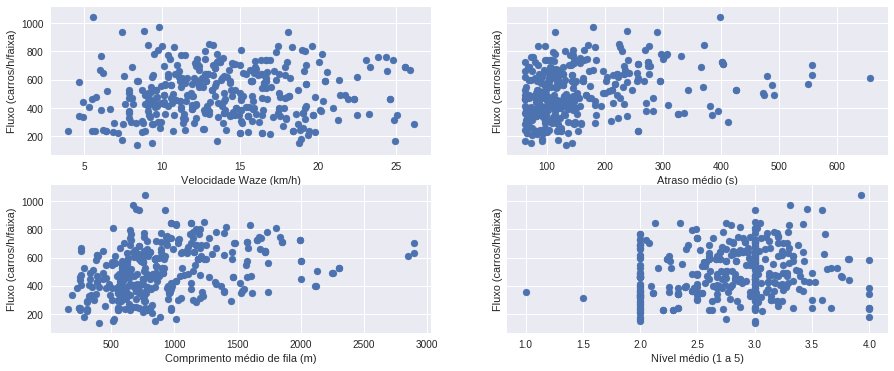

In [99]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(15,6))
ax1.scatter(flow_dataset['JamSpdKmPerHour'], flow_dataset["total_por_faixa"])
ax1.set_xlabel("Velocidade Waze (km/h)")
ax1.set_ylabel("Fluxo (carros/h/faixa)")

ax2.scatter(flow_dataset['JamTimeDelayInSeconds'], flow_dataset["total_por_faixa"])
ax2.set_xlabel("Atraso médio (s)")
ax2.set_ylabel("Fluxo (carros/h/faixa)")

ax3.scatter(flow_dataset['JamQtdLengthMeters'], flow_dataset["total_por_faixa"])
ax3.set_xlabel("Comprimento médio de fila (m)")
ax3.set_ylabel("Fluxo (carros/h/faixa)")

ax4.scatter(flow_dataset['JamIndLevelOfTraffic'], flow_dataset["total_por_faixa"])
ax4.set_xlabel("Nível médio (1 a 5)")
ax4.set_ylabel("Fluxo (carros/h/faixa)")

Linear Regression does not yield good results:

In [113]:
X = flow_dataset[['JamSpdKmPerHour',
                  'JamIndLevelOfTraffic',
                  'JamTimeDelayInSeconds',
                  'JamQtdLengthMeters'
                 ]]
y = flow_dataset['total_por_faixa']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

clf = linear_model.LinearRegression()

clf.fit(X_train,y_train)
print("R2 Linear Regression: ", clf.score(X_test, y_test))

R2:  0.138344610957


Nor does KNN:

In [114]:
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train,y_train)
print("R2 KNN: ", neigh.score(X_test, y_test))

R2:  0.148739662555


Next steps? Retry the approach with a more granular database (getting single data points, day by day, instead of averaging out throughou the entire period).